# Clusteren van Tweede Kamer moties
> Wie zet wat op de agenda?

- toc: false
- branch: master
- badges: true
- comments: true
- author: Jesse van Elteren
- image: images/wordcloud.png
- categories: []

![](moties/wordcloud.png)

En ja hoor, nog net voor de verkiezingen deel 2 van het motie-onderzoek! In dit deel kijk ik naar de inhoud van de moties. Op de moties te clusteren naar onderwerp gebruikte ik in eerste instantie een bekende techniek [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) techniek voor, maar via een gelukkig toeval op Linkedin kwam ik achter een gloednieuwe techniek die veel beter werkt! Longhow Lam heeft deze [toegepast op de kamerdebatten](https://www.linkedin.com/posts/longhowlam_top2vec-stem-helper-activity-6772061735844098048-zKd6) van de Tweede Kamer. Het [Top2Vec](https://github.com/ddangelov/Top2Vec) algorithme komt uiteindelijk tot ongeveer 250 topics, die ik weer heb samengevoegd tot 16. En het klopt verrassend goed! Echt weer zo'n voorbeeld van een doorbraak in machine learning die sneller en beter werkt waardoor oude technieken bij het grofvuil kunnen.

In [1]:
# hide
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
import math
from top2vec import Top2Vec
from scipy.special import softmax
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import altair as alt

KeyboardInterrupt: 

In [ ]:
# hide
DATA_DIR = Path('data')
def load(filename):
    f = open(DATA_DIR/filename,"rb")
    return pickle.load(f)
    
def save(data, filename):
    with open(DATA_DIR/filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


party_colors = {
  'CDA':'#5cb957',
  'ChristenUnie':'#00a5e8',
  'D66':'#04a438',
  'GroenLinks':'#48a641',
  'PVV':'#002759',
  'PvdA':'#df111a',
  'PvdD':'#006b2d',
  'SGP':'#d86120',
  'SP':'#e3001b',
  'VVD':'#ff7f0e',
  'DENK':'#17becf',
  'FVD':'#800000',
  'Groep Krol/vKA':'pink'}

In [ ]:
# hide
df = load("df_including_topics_full.pickle")
print(len(df))

In [ ]:
# hide
parties = ['VVD',
 'CDA',
 'ChristenUnie',
 'D66',
 'SGP',
 'FVD',
 'PVV',
 'PvdA',
 'DENK',
 'GroenLinks',
 'SP',
 'PvdD']

In [79]:
def postprocess_chart(chart):
    return chart.configure_axis(
        grid=False).configure_view(
        strokeWidth=0)

def normalize(df, field, on='Aantal'):
    sums = df.groupby(field)[on].transform('sum')
    df[on] = df[on].div(sums)
    return df

def rankify(df, field, on='Aantal'):
    df['Rank'] = df.groupby(field)[on].rank("dense", ascending=False)
    df.loc[df['Rank'] > 4, 'Rank'] = ''
    return df


## Welk soort onderwerpen staan op de agenda?
First things first, eerst kijken naar de ontwikkeling van de onderwerpen van de ingediende moties. We weten al dat het absoluut aantal moties stijgt, dus heb gekeken naar de relatieve verdeling van de onderwerpen.

In [47]:
# hide_input
# df.groupby(['Jaar', 'Topic']).size().unstack(fill_value=0)
source = df.groupby(['Kamer', 'Topic']).size().reset_index()
source = source.rename(columns={0:'Aantal moties'})
source.head()

# Overview of topic distribution over all years
alt.Chart(source).mark_bar().encode(
    x='Kamer:O',
    y=alt.Y('Aantal moties:Q', stack='normalize',axis=alt.Axis(format='%')),
    color=alt.Color('Topic:N'),
    # sort=alt.EncodingSortField('Aantal moties', order='descending'))
    # order=alt.Order('Aantal moties:Q',sort='descending')
    tooltip = 'Topic'
).properties(width=200, height=300)

alt.Chart(...)

Opvallend dat de verhoudingen redelijk stabiel zijn!
De onderwerpen verschuiven heel geleidelijk over de jaren. In de lift zitten: klimaat en energie, milieu en regelgeving (heel veel coronaregels zitten hier ook in gecategoriseerd), sociale zaken en wonen
Minder landbouw en dierenwelzijn, natuur en gaswinning, onderwijs en openbaar vervoer

## Meest actieve partijen per onderwerp
Sommige partijen profileren zich heel erg op bepaalde onderwerpen. Eens kijken we het actiefst is per onderwerp. Dat doen we op drie manieren
1. Het aantal moties
2. Het aantal succesvolle moties
3. Het aantal succesvolle moties per zetel
We nemen de ingediende moties tijdens de afgelopen kabinetsperiode als basis.

In [102]:
# hide_input
# Overview of topic 'owner' throughout the years
source = df[(df['Kamer'] == 'Rutte III') & (df['Indienende_partij'].isin(parties))]
source = source.groupby(['Indienende_partij','Topic']).size().reset_index(name='Aantal')
# sums = source.groupby('Topic')['Aantal'].transform('sum')
# source['Aantal'] = source['Aantal'].div(sums)
source['Rank'] = source.groupby('Topic')["Aantal"].rank("dense", ascending=False)
source.loc[source['Rank'] > 4, 'Rank'] = ''
base = alt.Chart(source)
chart = base.mark_rect().encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    color=alt.Color("Aantal:Q", 
                      scale = alt.Scale(scheme="greens")),
)
text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

In bovenstaande grafiek zien we bijvoorbeeld dat op Onderwijs de meeste moties worden ingediend door Groenlinks, gevolgd door de SP, PvdA en D66. Bekende patronen komen terug. Zo is PVV erg actief op justitie, en de PvdD op klimaat, dierenwelzijn milieu en natuur. Ook de enorme output van de SP valt op! Maar wie is het meest succesvol?

In [128]:
# hide_input
# Overview of topic 'owner' throughout the years
source = df[(df['Kamer'] == 'Rutte III') & (df['BesluitSoort'] == 1)& (df['Indienende_partij'].isin(parties))]
source = source.groupby(['Indienende_partij','Topic']).size().reset_index(name='Aantal')
# sums = source.groupby('Topic')['Aantal'].transform('sum')
# source['Aantal'] = source['Aantal'].div(sums)
source['Rank'] = source.groupby('Topic')["Aantal"].rank("dense", ascending=False)
source.loc[source['Rank'] > 4, 'Rank'] = ''
base = alt.Chart(source)
chart = base.mark_rect().encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    color=alt.Color("Aantal:Q", 
                      scale = alt.Scale(scheme="greens")),
)
text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

Kijken we naar het aantal succesvolle moties dan zien we daar ineens vier partijen bovendrijven: CDA, D66, GroenLinks en de VVD.

In [98]:
# hide
aantal_moties = df.groupby(['Kamer','Indienende_partij', 'Topic']).count()['Titel'].reset_index()
aantal_moties.rename(columns={'Titel':'aantal'}, inplace=True)
aantal_succesvol = df[df['BesluitSoort']==1].groupby(['Kamer','Indienende_partij','Topic']).count()['Titel'].reset_index()
aantal_succesvol.rename(columns={'Titel':'aantal_succesvol'}, inplace=True)
max_votes_per_party = df[(['Aantal_stemmen_'+p for p in get_largest_parties_chamber('Rutte III',12)]+['Kamer'])].groupby('Kamer').quantile(.95)
max_votes_per_party = pd.melt(max_votes_per_party, ignore_index=False).reset_index()
max_votes_per_party = max_votes_per_party.rename(columns={'variable':'Indienende_partij', 'value':'num_votes'})
max_votes_per_party['Indienende_partij'] = max_votes_per_party['Indienende_partij'].str[15:]
stats = aantal_moties.merge(max_votes_per_party).merge(aantal_succesvol)

stats['aantal_zetel'] = stats['aantal'] /stats['num_votes']
stats['aantal_succesvol_zetel'] = stats['aantal_succesvol'] /stats['num_votes']
stats.head()

Kamer Indienende_partij               Topic  aantal  num_votes  \
0  Balkenende IV               CDA      Algemene zaken      33       41.0   
1  Balkenende IV               CDA  Buitenlandse zaken      21       41.0   
2  Balkenende IV               CDA       Europese Unie       4       41.0   
3  Balkenende IV               CDA   Financiele sector      19       41.0   
4  Balkenende IV               CDA            Justitie      20       41.0   

   aantal_succesvol  aantal_zetel  aantal_succesvol_zetel  
0                30      0.804878                0.731707  
1                21      0.512195                0.512195  
2                 3      0.097561                0.073171  
3                18      0.463415                0.439024  
4                15      0.487805                0.365854

In [120]:
# hide_input
source = stats[stats['Kamer']=='Rutte III']
source['Rank'] = source.groupby('Topic')["aantal_succesvol_zetel"].rank("dense", ascending=False)
source.loc[source['Rank'] > 5, 'Rank'] = ''
base = alt.Chart(source)

chart = base.mark_rect().encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    color=alt.Color("aantal_succesvol_zetel:Q", 
                      scale = alt.Scale(scheme="greens"))
)

text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

Het aantal succesvolle moties per zetel: als je met je stem een gedeelte van een zetel koopt op 17 maart geeft bovenstaande overzicht weer hoeveel 'waar je voor je geld' krijgt, hoeveel succesvolle moties een zetel van een partij er doorheen krijgt per onderwerp. Het is weer een heel ander beeld: de christelijke partijen doen het heel erg goed (even gecheckt en inderdaad het Dik-Faber effect bij de ChristenUnie op Zorg, Voordewind op Buitenlandse zaken) en de SP komt een stuk minder terug. Opvallend ook dat D66 weinig doet op Onderwijs. Partijen die minder in de prijzen vallen zijn FvD (nr 5 op Europese Unie), de PVV nergens en de VVD op financiele sector (nr 5). Bij de VVD is dit te verklaren doordat ze veel zetels heeft en in de regering zit.

In [129]:
# hide
df[(df['Indienende_partij']=='PvdA') & (df['Kamer'] == 'Rutte III') & (df['BesluitSoort'] == 1) & (df['Topic'] == 'Sociale zaken')]['Indiener_persoon'].value_counts()

G.J. (Gijs) van Dijk    38
L.F. Asscher            17
W.J. Moorlag            11
J.W.M. Kerstens          9
K.A.E. van den Hul       6
H. Nijboer               4
A.H. Kuiken              4
Name: Indiener_persoon, dtype: int64

## Waar richten de partijen zich op?
In bovenstaande grafieken hebben we de partijen onderling vergeleken. Nu kijken we per partij op welk vlak ze het meest actief zijn

In [139]:
# hide
#normalized version
source = df[(df['Kamer'] == 'Rutte III') & (df['Indienende_partij'].isin(parties))]
source = source.groupby(['Indienende_partij','Topic']).size().reset_index(name='Aantal')
sums = source.groupby('Indienende_partij')['Aantal'].transform('sum')
source['Aantal'] = source['Aantal'].div(sums)
source['Rank'] = source.groupby('Indienende_partij')["Aantal"].rank("dense", ascending=False)
source.loc[source['Rank'] > 4, 'Rank'] = ''

In [143]:
# hide
base = alt.Chart(source)
chart = base.mark_circle().encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    size=alt.Size('sum(Aantal)', scale=alt.Scale(range=[0,500])),
    color=alt.Color("Indienende_partij", 
                      scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties])),
)

text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

Als een partij een aantal heel grote bollen heeft betekent dit dat de partij zich heel erg richt op dit onderwerp. Zijn er geen grote bollen binnen een partij is de inzet meer over de onderwerpen verspreid.
Algemene zaken, Onderwijs en Zorg krijgen bij veel partijen veel aandacht. Daarnaast hebben FvD, PVV en de PvdD een heel uitgesproken profiel.

In [16]:
# hide
aantal_moties = df.groupby(['Kamer','Indienende_partij', 'Topic']).count()['Titel'].reset_index()
aantal_moties.rename(columns={'Titel':'aantal'}, inplace=True)
aantal_succesvol = df[df['BesluitSoort']==1].groupby(['Kamer','Indienende_partij','Topic']).count()['Titel'].reset_index()
aantal_succesvol.rename(columns={'Titel':'aantal_succesvol'}, inplace=True)
max_votes_per_party = df[(['Aantal_stemmen_'+p for p in get_largest_parties_chamber('Rutte III',12)]+['Kamer'])].groupby('Kamer').quantile(.95)
max_votes_per_party = pd.melt(max_votes_per_party, ignore_index=False).reset_index()
max_votes_per_party = max_votes_per_party.rename(columns={'variable':'Indienende_partij', 'value':'num_votes'})
max_votes_per_party['Indienende_partij'] = max_votes_per_party['Indienende_partij'].str[15:]
stats = aantal_moties.merge(max_votes_per_party).merge(aantal_succesvol)

stats['aantal_zetel'] = stats['aantal'] /stats['num_votes']
stats['aantal_succesvol_zetel'] = stats['aantal_succesvol'] /stats['num_votes']
stats.head()

Kamer Indienende_partij               Topic  aantal  num_votes  \
0  Balkenende IV               CDA      Algemene zaken      33       41.0   
1  Balkenende IV               CDA  Buitenlandse zaken      21       41.0   
2  Balkenende IV               CDA       Europese Unie       4       41.0   
3  Balkenende IV               CDA   Financiele sector      19       41.0   
4  Balkenende IV               CDA            Justitie      20       41.0   

   aantal_succesvol  aantal_zetel  aantal_succesvol_zetel  
0                30      0.804878                0.731707  
1                21      0.512195                0.512195  
2                 3      0.097561                0.073171  
3                18      0.463415                0.439024  
4                15      0.487805                0.365854

# hide
## Ontwikkeling per partij

In [17]:
# hide
# this is not normalized yet!

def get_party_chart(source, partij, axis=True):
    source = source.groupby(['Kamer', 'Topic']).size().reset_index(name='Aantal moties')
    source = normalize(source, field='Kamer', on='Aantal moties')
    source = rankify(source, field='Kamer', on='Aantal moties')

    # Overview of topic distribution over all years
    import altair as alt
    if axis:
        chart = alt.Chart(source).mark_rect().encode(
        y=alt.Y('Topic:N'),
        x=alt.X('Kamer:O',axis=alt.Axis(title=partij)),
        color = alt.Color('Aantal moties:Q',scale = alt.Scale(scheme="greens"), legend=None),
        tooltip = 'Topic')
    else:
        chart = alt.Chart(source).mark_rect().encode(
        y=alt.Y('Topic:N', axis=None),
        x=alt.X('Kamer:O',axis=alt.Axis(title=partij)),
        color = alt.Color('Aantal moties:Q',scale = alt.Scale(scheme="greens"), legend=None),
        tooltip = 'Topic')
    text = alt.Chart(source).mark_text().encode(
        y=alt.Y('Topic:N'),
        x='Kamer:O',
        text=alt.Text('Rank:N'))
    return chart + text

legend = [False] * len(parties)
legend[0] = True
charts = [get_party_chart(df[df['Indienende_partij'] == partij], partij, legend[i]) for i, partij in enumerate(parties)]



In [19]:
# hide
import altair as alt
alt.hconcat(*charts)

alt.HConcatChart(...)

## Stemgedrag per onderwerp
Dan toch nog eens proberen het stemgedrag te visualiseren. Als de VVD iets indient voor de Financiele Sector betekent dit namelijk iets heel anders dan als de SP dat doet. In onderstaande plots staat per onderwerp het stemgedrag gevisualiseerd. Positief of negatief zegt niets, het gaat om partijen die dichtbij of ver weg van elkaar staan. PvdD en VVD vormen meestel de uitersten en verschillen dus het meeste op stemgedrag. Deze grafieken verklaren meestal zo'n 40%-55% van de variatie in het stemgedrag.

In [23]:
# hide
def get_stem_column(largest):
    return [c for c in df.columns if 'Stem_' in c and c != 'Stem_persoon' and c[5:] in largest]
    
def get_pca(df, n_components=1, num_largest=None, return_ratio=False):
    largest = parties
    stem_column = get_stem_column(largest)
    source_year = df[stem_column].dropna(axis=1, how='all').T
    X_year = SimpleImputer(strategy='most_frequent').fit_transform(source_year)
    pca = PCA(n_components = n_components)
    pca = pca.fit(X_year)
    print('explained variance by factors', pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())  
    res_year = pca.transform(X_year)
    source = pd.DataFrame(res_year)
    source['partij'] = source_year.T.columns.str[5:]
    source = source.rename(index=str, columns={0: "x", 1: "y"}).sort_values('x',ascending=False)
    return (source, pca.explained_variance_ratio_) if return_ratio else source

In [24]:
# hide
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
size=800
def pca_topic(df, topic, kamer, twodim=False):
    column_list = df.columns
    source = df[(df['Topic'] == topic) & (df['Kamer'] == kamer)]
    num_moties = len(source)
    if twodim:
        source, explained_variance_ratio_ = get_pca(source, n_components = 2, return_ratio=True)
    else:
        source, explained_variance_ratio_ = get_pca(source, n_components = 1, return_ratio=True)
    mid = (source['x'].max() + source['x'].min())/2
    median = source['x'].median()
    if source[source['partij'] =='VVD']['x'].values > median: # make sure that VVD is on the right part of the x-axis
        source['x'] += 2 * (mid - source['x'])
    if twodim:
        points = alt.Chart(source,width= size * explained_variance_ratio_[0],height = size * explained_variance_ratio_[1]).mark_point().encode(
        # x=alt.X('x:Q', axis=alt.Axis(title='Eerste factor')),
        # y=alt.Y('y:Q', axis=alt.Axis(title='Tweede factor')),
        x=alt.X('x:Q', axis=None),
        y=alt.Y('y:Q', axis=None),
        color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties]), legend=None),
        tooltip=['partij:N']
        )

        text = points.mark_text(
            align='left',
            baseline='middle',
            dx=np.random.uniform(0,10),
            dy=np.random.uniform(0,10)
            # opacity=0.5
        ).encode(
            text='partij:N'
        ).properties(
            title='Welke partijen lijken op elkaar'
        )

        return (points + text).configure_axis(
            grid=False).configure_view(
            strokeWidth=1)
        
    else:
        chart = alt.Chart(source,width=200,height = 50).mark_bar().encode(
        x=alt.X('partij:N',sort=alt.SortField(field="x", order='descending')),
        y=alt.Y('x:Q', axis = None),
        color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties]), legend=None),
    )
        chart.encoding.x.title = f'{topic} #{num_moties} {round(explained_variance_ratio_[0]*100)}%'

        
        return chart



In [26]:
# hide
topics = df[df['Kamer']=='Rutte III'].groupby('Topic').size().sort_values(ascending=False).index
for topic in topics:
    print(topic, end=' ')
    pca_topic(df, topic, 'Rutte III', twodim=True)

Zorg explained variance by factors [0.53065354 0.14020781] 0.6708613536085631
Onderwijs explained variance by factors [0.44061105 0.19470506] 0.635316111815432
Sociale zaken explained variance by factors [0.46731999 0.22256132] 0.6898813091708342
Algemene zaken explained variance by factors [0.37198469 0.22224194] 0.5942266306446831
Buitenlandse zaken explained variance by factors [0.44117723 0.21652791] 0.6577051431400569
Natuur & gaswinning explained variance by factors [0.47464803 0.19317995] 0.667827981054437
Klimaat & energie explained variance by factors [0.44447603 0.2583194 ] 0.7027954267724004
Justitie explained variance by factors [0.32782655 0.28769006] 0.6155166096151312
Landbouw & dierenwelzijn explained variance by factors [0.49906394 0.17142116] 0.6704851035768473
Milieu & regelgeving explained variance by factors [0.45626535 0.20003523] 0.6563005832264468
Pensioenstelsel explained variance by factors [0.46110948 0.23587915] 0.6969886307467013
Europese Unie explained var

In [27]:
# hide
charts = [pca_topic(df, topic, 'Rutte III') for topic in topics]

explained variance by factors [0.53065354] 0.530653544592846
explained variance by factors [0.44061105] 0.44061105270421863
explained variance by factors [0.46731999] 0.467319986706869
explained variance by factors [0.37198469] 0.37198469195238903
explained variance by factors [0.44117723] 0.4411772333931455
explained variance by factors [0.47464803] 0.47464803206026274
explained variance by factors [0.44447603] 0.44447602972352707
explained variance by factors [0.32782655] 0.3278265466344849
explained variance by factors [0.49906394] 0.49906394450323516
explained variance by factors [0.45626535] 0.45626534987316986
explained variance by factors [0.46110948] 0.4611094848506362
explained variance by factors [0.35604612] 0.35604612412753867
explained variance by factors [0.442064] 0.44206399782663197
explained variance by factors [0.40784905] 0.40784905392257886
explained variance by factors [0.35577433] 0.3557743296177252


In [31]:
# hide_input
n_rows = 4
column_charts = []
for cols in range(0,math.ceil(len(charts)/n_rows)):
    row_charts = [charts[cols*n_rows+rows] for rows in range(n_rows) if cols*n_rows+rows < len(charts)]
    column_charts.append(alt.hconcat(*row_charts))
alt.vconcat(*column_charts).configure_axis(
        grid=False).configure_view(
        strokeWidth=0)

alt.VConcatChart(...)

Het meest opvallend is dat FvD en PVV soms in het midden zitten en soms aan de rechterkant. Bij de Europese Unie mengen SP, PvdD en de SGP zich hier ook in. Als het gaat om pensioenen zitten ze juist meer aan de linkerkant. 
De groep PvdD, SP, GroenLinks, PvdA en DENK zit standaard links, alleen wederom bij de EU en pensioenstelsel wordt gehusseld.

## Onderzoek naar klimaat
Omdat ik denk dat klimaat de grootste uitdaging is voor de mens heb ik hier de subonderwerpen nog eens doorgenomen. Dan merk je dus weer dat zo'n model niet onfeilbaar is maar wel 90% accuraat categoriseert. Maar er zullen vast nog wat moties die over het klimaat gaan bij andere onderwerpen terecht zijn gekomen (milieu, natuur). Ook heel belangrijke onderwerpen, maar toch besloten het even bij het klimaat te houden.

In [78]:
# Overview of topic distribution over all years
source = df[(~df['Klimaat'].isnull()) & (df['Kamer']=='Rutte III')]
source = source.groupby(['Klimaat','Indienende_partij']).size().reset_index(name='Aantal')
chart = alt.Chart(source).mark_bar().encode(
    x=alt.X('Indienende_partij:O', sort=alt.EncodingSortField(field="Aantal", op="sum", order='descending')),
    y=alt.Y('Aantal:Q'),
    color=alt.Color('Klimaat:N'),
    tooltip = 'Klimaat:O'
).properties(title='Aantal ingediende moties')

source = df[(~df['Klimaat'].isnull()) & (df['Kamer']=='Rutte III') & df['BesluitSoort']==1]
source = source.groupby(['Klimaat','Indienende_partij']).size().reset_index(name='Aantal')
chart2 = alt.Chart(source).mark_bar().encode(
    x=alt.X('Indienende_partij:O', sort=alt.EncodingSortField(field="Aantal", op="sum", order='descending')),
    y=alt.Y('Aantal:Q'),
    color=alt.Color('Klimaat:N'),
    tooltip = 'Klimaat:O'
).properties(title='Aantal succesvolle moties')

postprocess_chart(chart | chart2)

alt.HConcatChart(...)

De vraag is op welke partij je stemt: PvdD dient enorm veel moties in en bepaalt hier wel het debat mee. Maar de succesvolle partijen zijn meer D66, GroenLinks en CDA. En hier houdt het een beetje op, je moet namelijk uiteindelijk toch de moties gaan lezen om te kijken wat er wordt voorgesteld.

## Bijlage: classificering van de onderwerpen

In [34]:
# hide
model = Top2Vec.load("data/doc2vec_deep_bigram_enhanced_stopwords")
num_topics = 16
reduced_topics = model.hierarchical_topic_reduction(num_topics)
topic_words, word_scores, topic_nums = model.get_topics(reduced=True)

In [35]:
# hide
def generate_topic_wordcloud(self, topic_num, background_color="black", reduced=False, text = None):
        """
        Create a word cloud for a topic.
        A word cloud will be generated and displayed. The most semantically
        similar words to the topic will have the largest size, less similar
        words will be smaller. The size is determined using the cosine distance
        of the word vectors from the topic vector.
        Parameters
        ----------
        topic_num: int
            The topic number to search.
        background_color : str (Optional, default='white')
            Background color for the word cloud image. Suggested options are:
                * white
                * black
        reduced: bool (Optional, default False)
            Original topics are used by default. If True the
            reduced topics will be used.
        Returns
        -------
        A matplotlib plot of the word cloud with the topic number will be
        displayed.
        """

        if reduced:
            self._validate_hierarchical_reduction()
            self._validate_topic_num(topic_num, reduced)
            word_score_dict = dict(zip(self.topic_words_reduced[topic_num],
                                       softmax(self.topic_word_scores_reduced[topic_num])))
        else:
            self._validate_topic_num(topic_num, reduced)
            word_score_dict = dict(zip(self.topic_words[topic_num],
                                       softmax(self.topic_word_scores[topic_num])))

        plt.figure(figsize=(4, 1),
                   dpi=200)
        plt.axis("off")
        plt.imshow(
            WordCloud(width=400,
                      height=100,
                      background_color=background_color).generate_from_frequencies(word_score_dict))
        plt.title(f'Onderwerp #{topic_num}, ingedeeld als: {text}', loc='left', fontsize=6, pad=1)
model.generate_topic_wordcloud = generate_topic_wordcloud

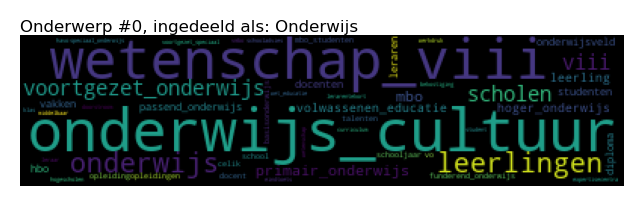

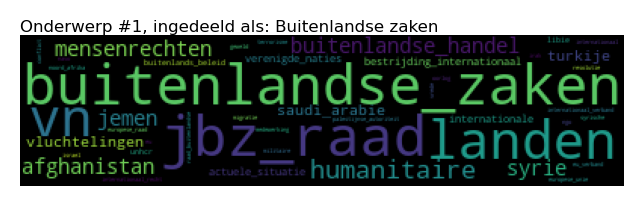

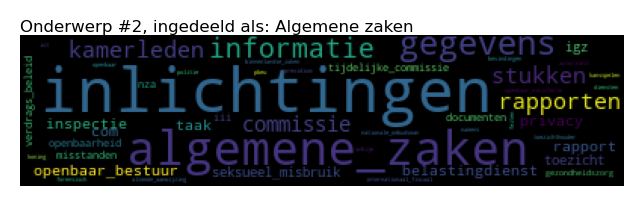

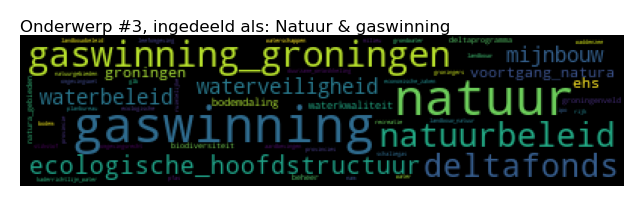

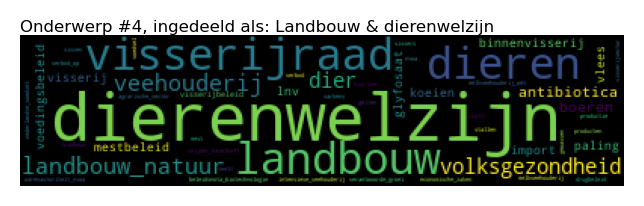

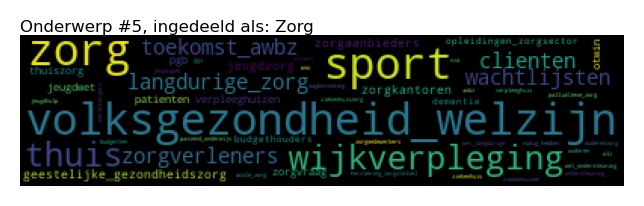

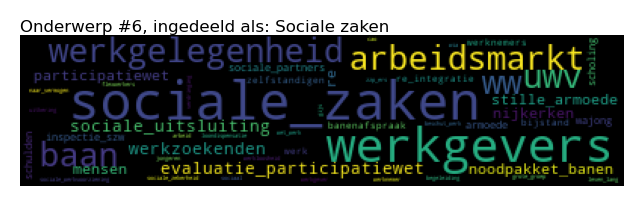

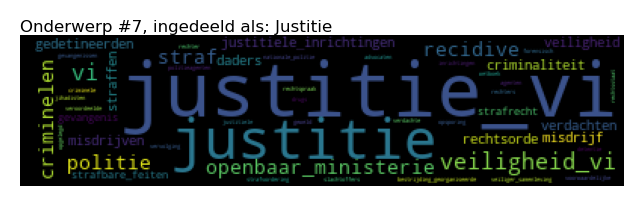

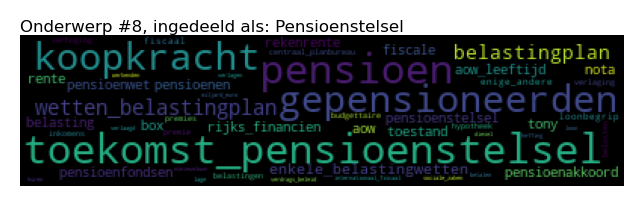

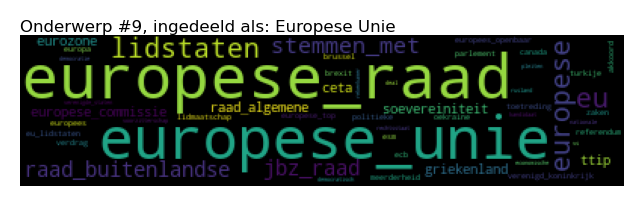

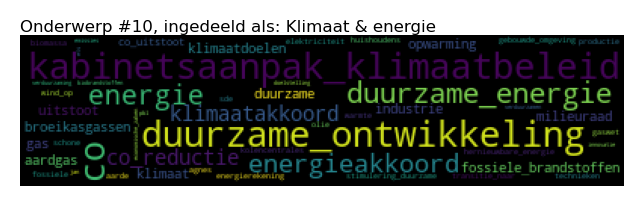

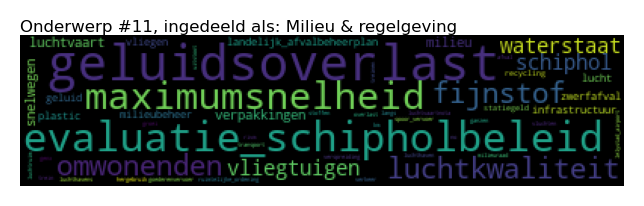

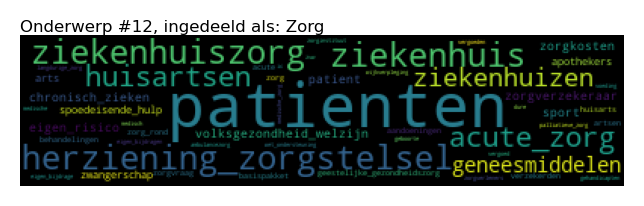

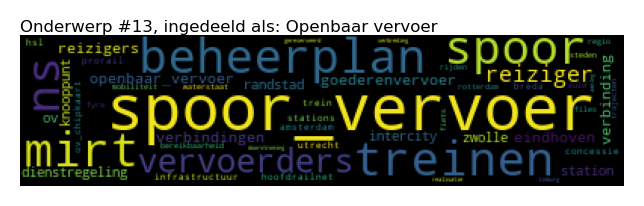

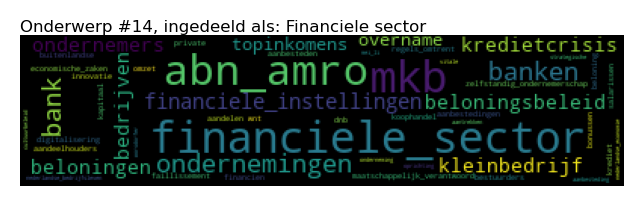

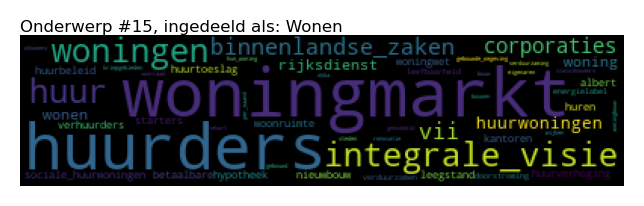

In [40]:
# hide_input

topics = {
  0: 'Onderwijs',  
  1: 'Buitenlandse zaken',  
  2: 'Algemene zaken',  
  3: 'Natuur & gaswinning',  
  4: 'Landbouw & dierenwelzijn',  
  5: 'Zorg',  
  6: 'Sociale zaken',  
  7: 'Justitie',  
  8: 'Pensioenstelsel',  
  9: 'Europese Unie',  
  10: 'Klimaat & energie',  
  11: 'Milieu & regelgeving',  
  12: 'Zorg',  
  13: 'Openbaar vervoer',  
  14: 'Financiele sector',  
  15: 'Wonen'
  }
for i, topic in enumerate(topic_words):
    # print(f'\nOnderwerp {i+1}, geclassificeerd als: {topics[i]}:\n{words}')
    model.generate_topic_wordcloud(model, topic_num = i, reduced=True, text = topics[i])